# Creating an Audio Classifier Model

### Import the libraries

In [37]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import librosa
import math

### Verify the library versions

In [38]:
print('Numpy ' + np.__version__)
print('Tensorflow ' + tf.__version__)

Numpy 1.26.2
Tensorflow 2.14.0


### Model Parameters

In [39]:
tflite_model_name = 'audio_classifier'

tags = {
        0:'none', 
        1:'hello',
        2:'khadas',
        3:'vim',
        4:'edge',
        5:'tone',
        6:'mind'
}

n_tags = len(tags)

### Dataset Parameters

In [40]:
n_samples = 20
duration = 5

sr = 22050          # sampling rate
scale = sr * duration # no. of samples
n_fft = 4096        # fft size
hop_length = 512    # interval size
n_mels = 256        # no. of mel bank
fmax = 8000         # frequency range 0 - ..

### Create the dataset

In [41]:
spectrogram_dataset = np.empty((0, n_mels, math.ceil(scale / hop_length)), dtype=np.float32)            # log_mel_spectrogram
tag_dataset = np.array([], dtype=np.int32)                                                              # tags

for tag in tags:
    for idx in range(n_samples):
        scale, sr = librosa.load(f'./datasets/{tags[tag]}/{tags[tag]}-{idx}.wav')
        mel_spectrogram = librosa.feature.melspectrogram(y=scale, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
        spectrogram_dataset = np.append(spectrogram_dataset, np.array([log_mel_spectrogram], dtype=np.float32), axis=0)
        tag_dataset = np.append(tag_dataset, np.array([tag], dtype=np.int32))
        

In [42]:
tag_dataset.dtype

dtype('int32')

In [43]:
n_pairs = len(tag_dataset)
print('Number of records:', n_pairs)

Number of records: 140


### Visualize a data sample

(256, 216, 1)


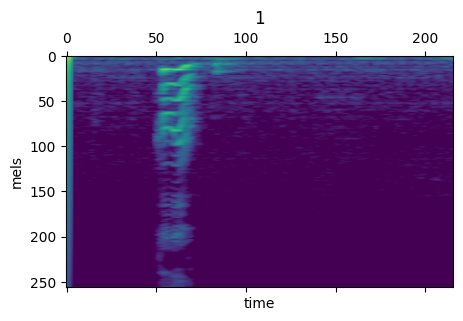

In [44]:
data_num = 24

fig, (ax) = plt.subplots(ncols=1, figsize=(5, 3))
ax.set(title=tag_dataset[data_num], xlabel='time', ylabel='mels')
ax.matshow(spectrogram_dataset[data_num], interpolation=None, aspect='auto')

input_shape = spectrogram_dataset[data_num].shape

input_shape = input_shape + (1,)
print(input_shape)

### Create a model

In [45]:
model = keras.Sequential([
    keras.layers.Conv2D(16, 5, activation='relu', input_shape=input_shape),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, 5, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(128, 3, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(128, 3, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(n_tags)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 252, 212, 16)      416       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 126, 106, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 122, 102, 32)      12832     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 61, 51, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 59, 49, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 29, 24, 64)       

### Train the model

In [46]:
history = model.fit(
                spectrogram_dataset,
                tag_dataset,
                epochs=50,
                batch_size=50
)

Epoch 1/50
3/3 [==============================] - 1s 259ms/step - loss: 3.5137 - accuracy: 0.1857
Epoch 2/50
3/3 [==============================] - 1s 270ms/step - loss: 2.0934 - accuracy: 0.1429
Epoch 3/50
3/3 [==============================] - 1s 261ms/step - loss: 1.9894 - accuracy: 0.1286
Epoch 4/50
3/3 [==============================] - 1s 274ms/step - loss: 1.9510 - accuracy: 0.1214
Epoch 5/50
3/3 [==============================] - 1s 269ms/step - loss: 1.9477 - accuracy: 0.1214
Epoch 6/50
3/3 [==============================] - 1s 258ms/step - loss: 1.9435 - accuracy: 0.1143
Epoch 7/50
3/3 [==============================] - 1s 263ms/step - loss: 1.9428 - accuracy: 0.1786
Epoch 8/50
3/3 [==============================] - 1s 268ms/step - loss: 1.9507 - accuracy: 0.1429
Epoch 9/50
3/3 [==============================] - 1s 273ms/step - loss: 1.9395 - accuracy: 0.1571
Epoch 10/50
3/3 [==============================] - 1s 268ms/step - loss: 1.9361 - accuracy: 0.1500
Epoch 11/50
3/3 [==

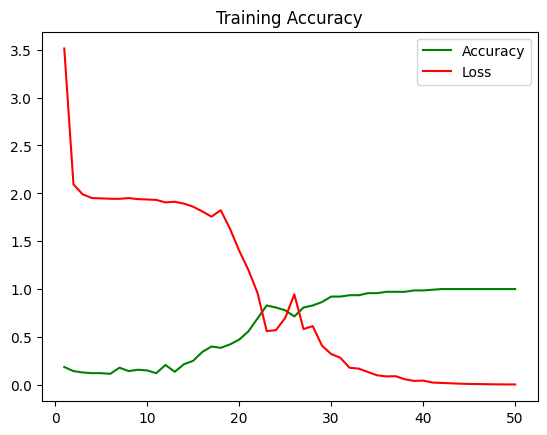

In [47]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'g', label='Accuracy')
plt.plot(epochs, loss, 'r', label='Loss')
plt.title('Training Accuracy')
plt.legend()

### Observing the predictions

In [48]:
predictions = model.predict(np.array(spectrogram_dataset))

for i, j, k in zip(range(n_pairs), predictions, tag_dataset):
    print(i, tags[k], '->', tags[np.argmax(j)])

5/5 [==============================] - 0s 55ms/step
0 none -> none
1 none -> none
2 none -> none
3 none -> none
4 none -> none
5 none -> none
6 none -> none
7 none -> none
8 none -> none
9 none -> none
10 none -> none
11 none -> none
12 none -> none
13 none -> none
14 none -> none
15 none -> none
16 none -> none
17 none -> none
18 none -> none
19 none -> none
20 hello -> hello
21 hello -> hello
22 hello -> hello
23 hello -> hello
24 hello -> hello
25 hello -> hello
26 hello -> hello
27 hello -> hello
28 hello -> hello
29 hello -> hello
30 hello -> hello
31 hello -> hello
32 hello -> hello
33 hello -> hello
34 hello -> hello
35 hello -> hello
36 hello -> hello
37 hello -> hello
38 hello -> hello
39 hello -> hello
40 khadas -> khadas
41 khadas -> khadas
42 khadas -> khadas
43 khadas -> khadas
44 khadas -> khadas
45 khadas -> khadas
46 khadas -> khadas
47 khadas -> khadas
48 khadas -> khadas
49 khadas -> khadas
50 khadas -> khadas
51 khadas -> khadas
52 khadas -> khadas
53 khadas -> khada

### Export the model to tflite

In [49]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpveggqeu6/assets


INFO:tensorflow:Assets written to: /tmp/tmpveggqeu6/assets
2023-12-06 11:20:14.302424: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-06 11:20:14.302468: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-06 11:20:14.302640: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpveggqeu6
2023-12-06 11:20:14.303888: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-06 11:20:14.303903: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpveggqeu6
2023-12-06 11:20:14.307578: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-06 11:20:14.367377: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpveggqeu6
2023-12-06 11:20:14.383682: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

1675596